**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

----

In [1]:
# показывать выдачу всех строк ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import numpy as np
import numpy.random as rng
# import pandas as pd

# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [3]:
import sys 
import logging

logging.basicConfig(
    format=u'[%(levelname)-8s] %(asctime)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
    stream=sys.stdout,
    )

## генерируем датасет

In [32]:
# # from sklearn.datasets import fetch_california_housing
# # from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# X,target = make_blobs( n_samples=1_000, centers=2, cluster_std=[1.7,1.8] )
X,target = make_regression(n_samples=1_000,n_features=1,noise=9.1, shuffle=True,)

# докидываем свободный член
X = np.hstack([X,np.ones((X.shape[0],1))])

print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(1000, 2) (1000,)


In [33]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis] for t in [ target_train, target_val, target_test ] ]

In [34]:
logging.getLogger().setLevel(logging.CRITICAL) 
InteractiveShell.ast_node_interactivity = 'last_expr'

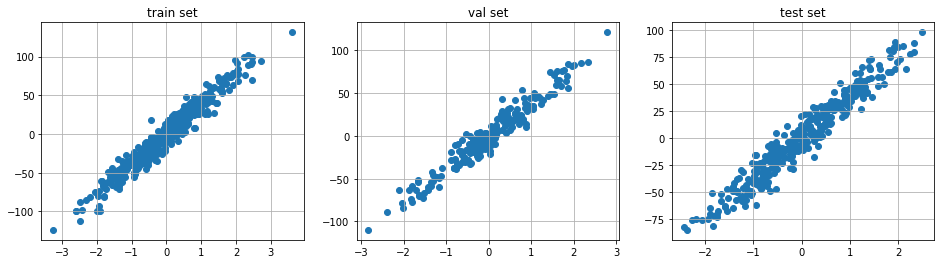

In [35]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],y_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],y_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],y_test)
ax2.set_title('test set')
ax2.grid()

In [36]:
logging.getLogger().setLevel(logging.DEBUG) 
InteractiveShell.ast_node_interactivity = 'all'

## LinearRegression + MSQE + SGD

In [37]:
from lib.initiator.linear import UniformInitiatorLinearModel

from lib.model.linear import LinearModel
model = LinearModel(
    initiator=UniformInitiatorLinearModel(
    # initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
    )
)

model.weight.shape

(2, 1)

In [43]:
from lib.loss.msqe import MSQE
loss_train = MSQE(model,normalize_gradient=False)
loss_val = MSQE(model)

In [44]:
# y_train

In [45]:
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная

from lib.optimizer.gd import SGD # метод  оптимизации стохастический градиентный спуск 

from lib.optimizer.breaker import ThresholdBreaking # прерывание по достижению порога значения ф-ции потери
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери
from lib.optimizer.breaker import DifferenceBreaking # прерывание при отсутствии изменения значения ф-ции потери

lra = ConstLRA(.1)

model = SGD(
    loss=loss_train,
    loss_val=loss_val,
    lra=lra,
    #breaker_val=[GrowthBreaking(delta=1e-3),DifferenceBreaking(delta=1e-1)]
    breaker_val=[GrowthBreaking(delta=1e-3),],
    momentum=.01
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=100,
    batch_size=y_train.shape[0]//10,
)

  4%|▍         | 4/100 [00:00<00:00, 676.80it/s, loss=262, lr=0.1]

[INFO    ] 2021-10-05 21:06:03 | GrowthBreaking: significant increase in the loss function has been detected


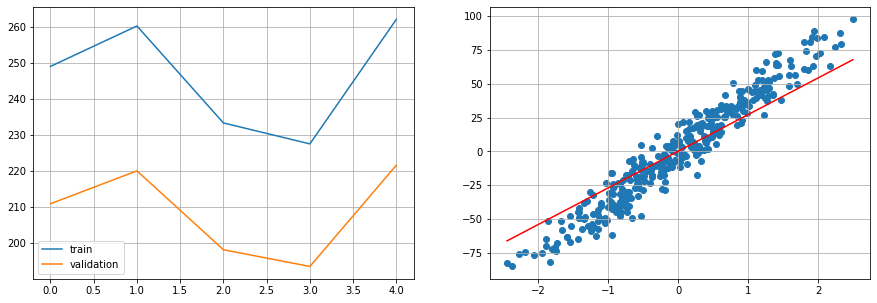

In [46]:
x = np.linspace(X_test.min(),X_test.max(),100)[:,np.newaxis]
x = np.hstack([x,np.ones((x.shape[0],1))])
p = model.predict(x)

fig,(ax0,ax1) = plt.subplots(1,2,figsize=(15,5))
ax0.plot(loss_train.history,label='train')
ax0.plot(loss_val.history,label='validation')
ax0.grid()
ax0.legend()

ax1.scatter(X_test[:,0],y_test)
ax1.plot(x[:,0],p,c='r')
ax1.grid()
